In [71]:
import pandas as pd
import numpy as np

from impute_transform import ImputeTransform
from supervised_functions import *
from fancyimpute import *

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.style.use('ggplot')

In [6]:
train_data = pd.read_csv('data/train_data.csv')

# Supervised Learning in ADHD

## Introduction

## Overview of Methods
 - EDA: Missing Value Imputation
 - Model Metrics
 - Tuning The Models

## Overview of Results (?)

---

# EDA: Missing Value Imputation

Missing values are common in clinical research (e.g., the participant did not complete a task or missed a question on a survey) but impact data analysis. It is not appropriate to drop subjects with any missing data because that would limit our dataset. Single imputation, where you replace missing values on a variable with one specific value, is not a good option.

The Python library, [fancyimpute](https://pypi.python.org/pypi/fancyimpute), gives us some good options for dealing with this. The following section will explore which algorithm is the best option for this dataset.

In [53]:
# Make all solver objects
KNN_solver = KNN(k=5)
softimpute_solver = SoftImpute()
MICE_solver = MICE()
simple_solver = SimpleFill()
iterativeSVD_solver = IterativeSVD()
mf_solver = MatrixFactorization()

solver_list = [KNN_solver, softimpute_solver, MICE_solver,
               simple_solver, iterativeSVD_solver, mf_solver]
solver_names = ['KNN', 'SoftImpute', 'MICE', 'SimpleFill',
                   'IterativeSVD', 'MatrixFactorization']

In [54]:
# Create a dataframe from the complete data in `train_data`. Then, randomly insert some NaNs for MSE testing.
nan_inserted_data, missing_mask, complete_df = create_missing_data(train_data)

In [55]:
%%capture
mse_df = create_mse_df(nan_inserted_data, missing_mask,
                       complete_df, solver_list, solver_names)

Which method had the most "minimum MSEs" across the columns?

In [56]:
min_mse(mse_df, solver_names)

KNN Frequency of Minimum MSE:                     4 of 35 features
SoftImpute Frequency of Minimum MSE:              2 of 35 features
MICE Frequency of Minimum MSE:                    2 of 35 features
SimpleFill Frequency of Minimum MSE:              1 of 35 features
IterativeSVD Frequency of Minimum MSE:            3 of 35 features
MatrixFactorization Frequency of Minimum MSE:     23 of 35 features


The MatrixFactorization algorithm is the best option for imputation.

---

# EDA: Checking for Leaky Data

> Leakage is a pervasive challenge in applied machine learning, causing models to over-represent their generalization error and often rendering them useless in the real world. It can caused by human or mechanical error, and can be intentional or unintentional in both cases. [Data Leakage - Kaggle](https://www.kaggle.com/wiki/Leakage)

A quick check for data leakage is best practice when approaching a new dataset.

In [57]:
# do the things

---

# Models

One question the ADHD Research Lab had about their data was "Do more advanced machine learning techniques outperform logistic regression?". To answer this question, I picked four models:
 * Logistic Regression
 * Random Forest
 * Gradient Boosting
 * XGBoost
 
Next, I examined the performance of these models on the following datasets:
 * DX ~ TMCQ & neuro features
 * DXSUB ~ TMCQ & neuro features
 * DX ~ TMCQ features only
 * DX ~ Neuro features only
 
I used k-fold cross-validation (k=10) on these models and datasets, and examined these metrics:
 * ROC AUC
 * Log Loss
 
*Notes:*
The metrics below are obtained from models using the **defaults** in sklearn and xgboost. None of the models are tuned at this point.
Due to the lengthy computation time this process requires, I have run model_metrics.py on the different datasets and obtained CSVs for each. 

In [87]:
roc_auc = pd.read_csv('csv_10/ROC_AUC.csv', index_col=0)
log_loss = pd.read_csv('csv_10/Log_Loss.csv', index_col=0)

model_dict = {
              'Logistic Regression': {'name': 'LogReg', 'linestyle': 'solid', 'marker': 'o', 'color':'#ff9000'},
              'Random Forest': {'name': 'RandomForest', 'linestyle': 'solid', 'marker': 'o', 'color':'#56B4E9'},
              'Gradient Boosting': {'name': 'GradientBoosting', 'linestyle': 'solid', 'marker': 'o', 'color':'#009E73'},
              'XGBoost': {'name': 'XGB', 'linestyle': 'solid', 'marker': 'o', 'color':'#CC79A7'}
              }

metric_dict = {
                'ROC_AUC':
                    {'Title': 'ROC AUC by Model',
                     'ylabel': 'ROC AUC Score',
                     'dataframe': roc_auc,
                     'col_names': ['DX~All', 'DXSUB~All', 'DX~TMCQ', 'DX~Neuro']},
                'LogLoss':
                    {'Title': 'Log Loss by Model',
                     'ylabel': 'abs(Log loss) Score',
                     'dataframe': -log_loss,
                     'col_names': ['DX~All', 'DXSUB~All', 'DX~TMCQ', 'DX~Neuro']},
               }

## Model Metrics

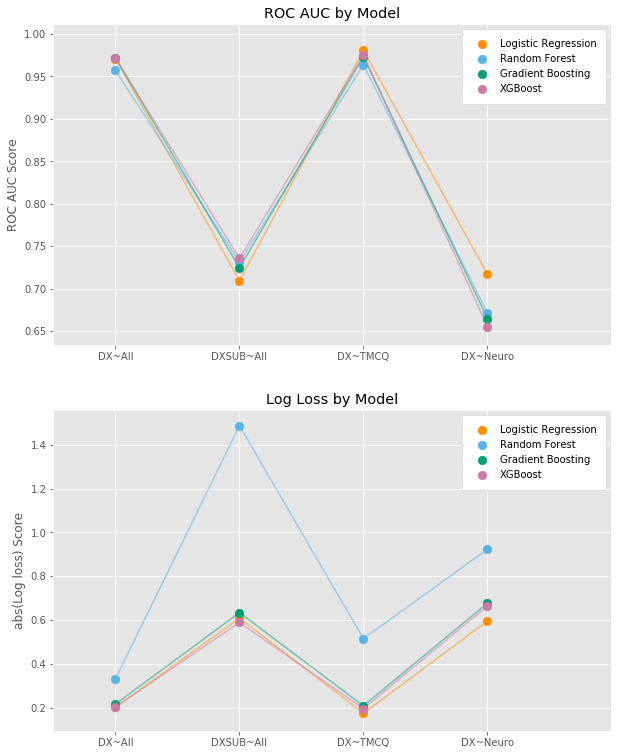

In [92]:
fig, axs = plt.subplots(2,1, figsize=(10,13))
_ = create_metric_graph(model_dict, metric_dict, axs)

Recall:
 * Higher ROC AUC score == **Better** Performance
 * Higher abs(Log Loss) score == **Worse** Performance
 
We can conclude a few things from these graphs:
 * Random Forest has the worst performance in terms of log loss
 * The datasets DX~All and DX~TMCQ have good general performance, across models. The models have a harder time predicting DXSUB~All and DX~Neuro.

It's hard to tell much beyond that because of the scale on the y-axis, so let's take a closer look.
 * We'll drop Random Forest in these metrics because of its poor log loss scores
 * We'll examine DX~All and DX~TMCQ together, and DXSUB~All, DX~Neuro because of the similarity in y-axis scores.

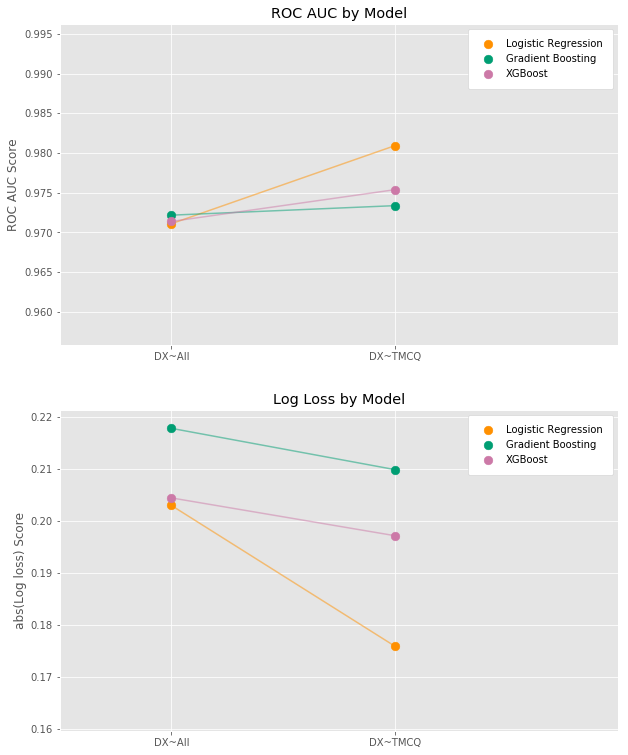

In [104]:
model_dict_no_rf = {
              'Logistic Regression': {'name': 'LogReg', 'linestyle': 'solid', 'marker': 'o', 'color':'#ff9000'},
              'Gradient Boosting': {'name': 'GradientBoosting', 'linestyle': 'solid', 'marker': 'o', 'color':'#009E73'},
              'XGBoost': {'name': 'XGB', 'linestyle': 'solid', 'marker': 'o', 'color':'#CC79A7'}
              }

metric_dict = {
                'ROC_AUC':
                    {'Title': 'ROC AUC by Model',
                     'ylabel': 'ROC AUC Score',
                     'dataframe': roc_auc,
                     'col_names': ['DX~All', 'DX~TMCQ']},
                'LogLoss':
                    {'Title': 'Log Loss by Model',
                     'ylabel': 'abs(Log loss) Score',
                     'dataframe': -log_loss,
                     'col_names': ['DX~All', 'DX~TMCQ']},
               }

fig, axs = plt.subplots(2,1, figsize=(10,13))
_ = create_metric_graph(model_dict_no_rf, metric_dict, axs)

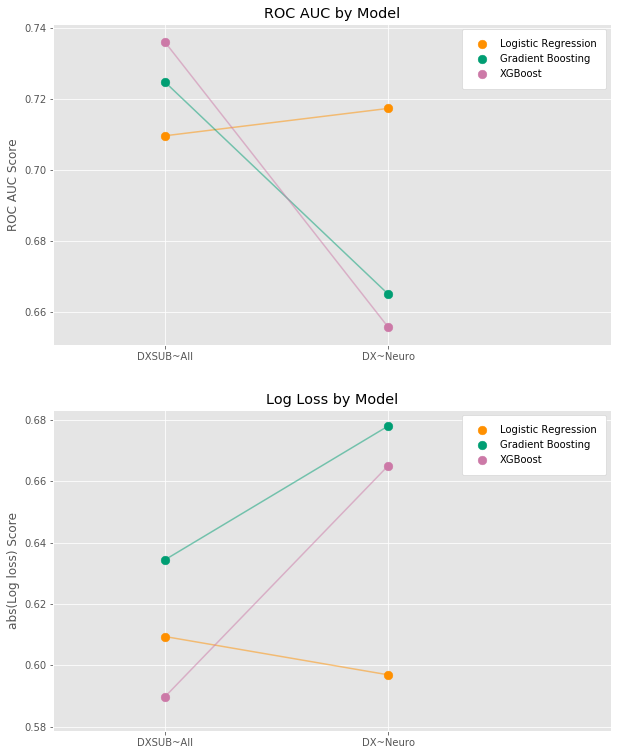

In [105]:
metric_dict = {
                'ROC_AUC':
                    {'Title': 'ROC AUC by Model',
                     'ylabel': 'ROC AUC Score',
                     'dataframe': roc_auc,
                     'col_names': ['DXSUB~All', 'DX~Neuro']},
                'LogLoss':
                    {'Title': 'Log Loss by Model',
                     'ylabel': 'abs(Log loss) Score',
                     'dataframe': -log_loss,
                     'col_names': ['DXSUB~All', 'DX~Neuro']},
               }

fig, axs = plt.subplots(2,1, figsize=(10,13))
_ = create_metric_graph(model_dict_no_rf, metric_dict, axs)

---

# Tuning the Models